# SHAP Tutorial 
<br>
Course sections:
<ol>
<li> SHAP values
<li> SHAP aggregations
    <ol>
    <li> Force plots
    <li> Mean SHAP
    <li> Beeswarm
    <li> Violin
    <li> Heatmap
    <li> Dependence
    </ol>
<li> Custom SHAP plots
<li> Binary and categorical target variables 
<li> SHAP interaction values
<li> Categorical features
</ol>
<br>
<b>Dataset:</b> https://archive.ics.uci.edu/ml/datasets/Abalone

In [1]:
#imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import shap
shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Dataset

In [2]:
#import dataset
data = pd.read_csv("../data/abalone.data",
                  names=["sex","length","diameter","height",
                         "whole weight","shucked weight",
                         "viscera weight","shell weight",
                         "rings"])

print(len(data))
data.head()

4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Text(0.5, 0, 'whole weight')

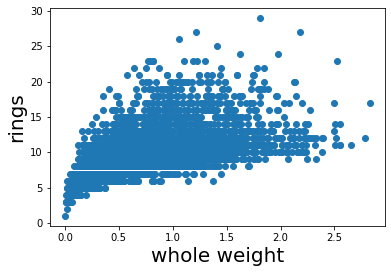

In [3]:
#Plot 1: whole weight
plt.scatter(data['whole weight'],data['rings'])
plt.ylabel('rings',size=20)
plt.xlabel('whole weight',size=20)

Text(0.5, 0, 'sex')

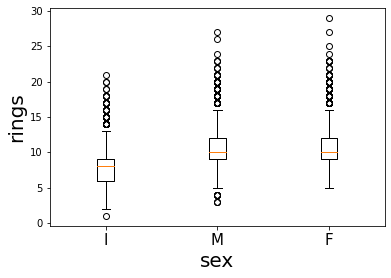

In [4]:
#Plot 2: sex
plt.boxplot(data[data.sex=='I']['rings'],positions=[1])
plt.boxplot(data[data.sex=='M']['rings'],positions=[2])
plt.boxplot(data[data.sex=='F']['rings'],positions=[3]) 

plt.xticks(ticks=[1,2,3],labels=['I', 'M', 'F'],size= 15)
plt.ylabel('rings',size=20)
plt.xlabel('sex',size=20)

<AxesSubplot:>

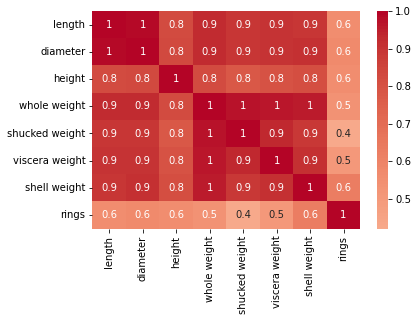

In [5]:
#Plot 3: Correlation heatmap
cont = ["length","diameter","height",
        "whole weight","shucked weight",
        "viscera weight","shell weight",
        "rings"]
corr_matrix = pd.DataFrame(data[cont],columns=cont).corr()

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center = 0,
            annot=True,
            fmt='.1g')

# Feature Engineering

In [6]:
y = data['rings']
X = data[["sex","length","height",
          "shucked weight","viscera weight","shell weight"]]

In [7]:
#Create dummy variables
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex', axis=1)

X.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


# Modelling

In [8]:
#Train model
model = xgb.XGBRegressor(objective="reg:squarederror") 
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Text(0.5, 0, 'Actual')

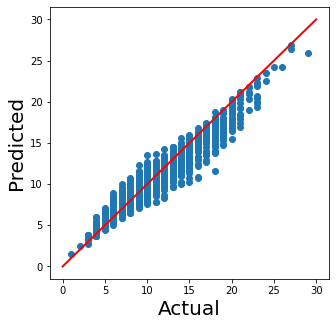

In [9]:
#Get predictions
y_pred = model.predict(X)

#Model evaluation
plt.figure(figsize=(5, 5))

plt.scatter(y,y_pred)
plt.plot([0, 30], 
         [0, 30], 
         color='r', 
         linestyle='-', 
         linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

# 1) Standard SHAP values

In [10]:
#Get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

#shap_values = explainer(X[0:100])

In [11]:
np.shape(shap_values.values)

(4177, 8)

## Waterfall plot

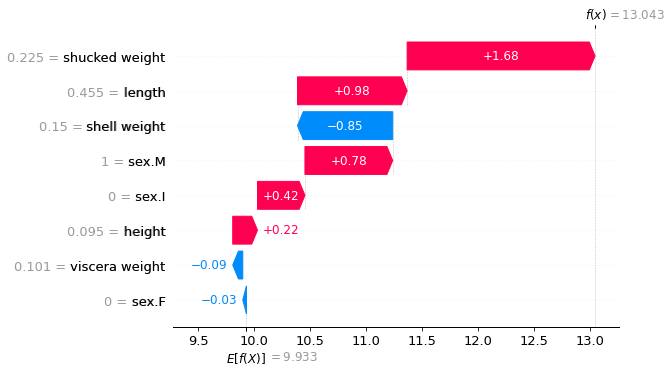

In [17]:
# Waterfall plot for first observation

#set face color white
shap.plots.waterfall(shap_values[0])

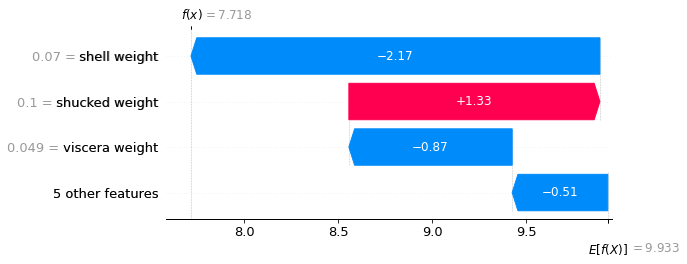

In [10]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[1], max_display=4)

# 2) SHAP aggregations

<b>Note:</b> from here on we only consider the continous target variable 

## Force plot

In [24]:
shap.plots.force(shap_values[0])

## Stacked force plot

In [25]:
shap.plots.force(shap_values[0:100])

## Absolute Mean SHAP

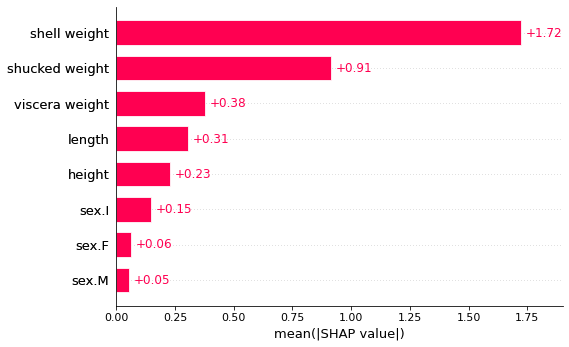

In [26]:
shap.plots.bar(shap_values)

## Beeswarm plot

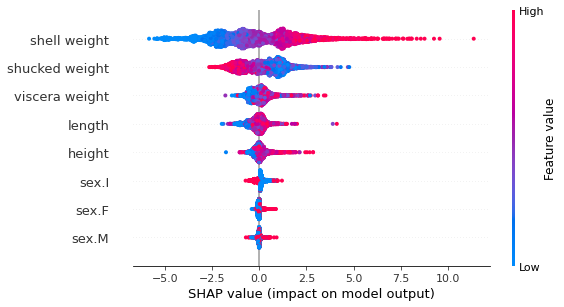

In [60]:
shap.plots.beeswarm(shap_values)

## Violin plot

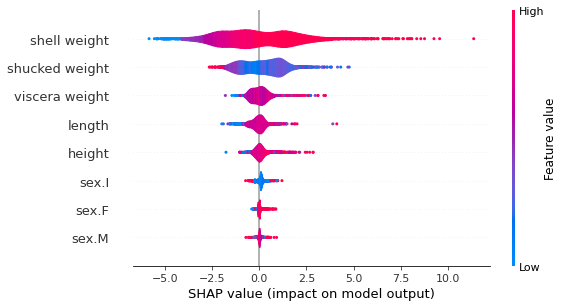

In [61]:
# violin plot
shap.plots.violin(shap_values)

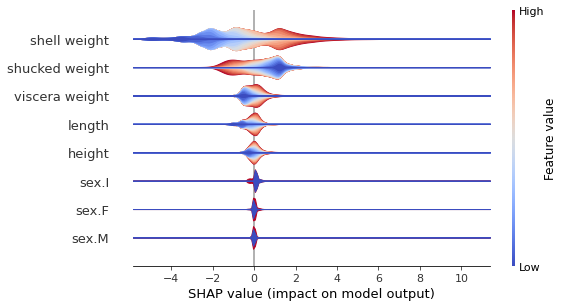

In [62]:
# layered violin plot
shap.plots.violin(shap_values, plot_type="layered_violin")

## Heamap

In [63]:
# heatmap
shap.plots.heatmap(shap_values)

: 

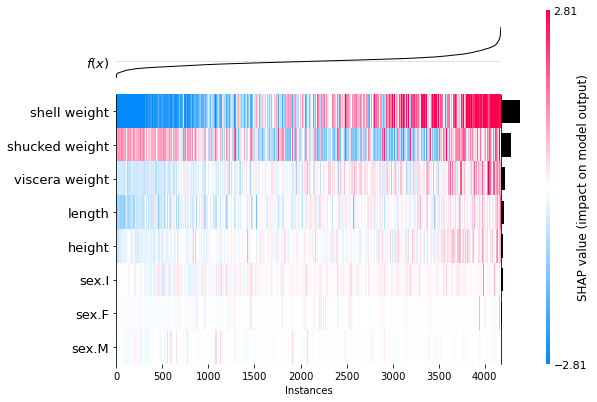

In [17]:
# order by predictions
order = np.argsort(y_pred)
shap.plots.heatmap(shap_values, instance_order=order)

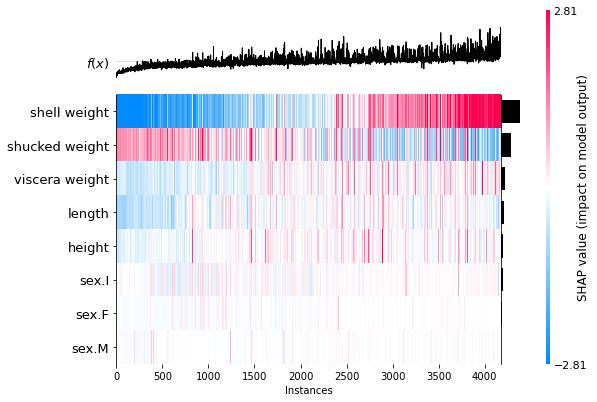

In [16]:
# order by shell weight value
order = np.argsort(data['shell weight'])
shap.plots.heatmap(shap_values, instance_order=order)

## Dependence plots

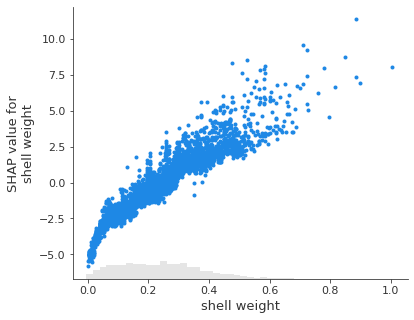

In [26]:
#Plot 1: shell weight
shap.plots.scatter(shap_values[:,"shell weight"])

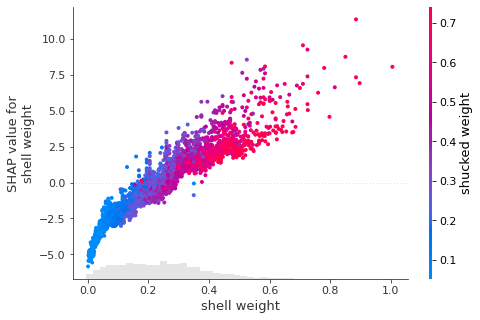

In [27]:
shap.plots.scatter(shap_values[:,"shell weight"],
                   color=shap_values[:,"shucked weight"])

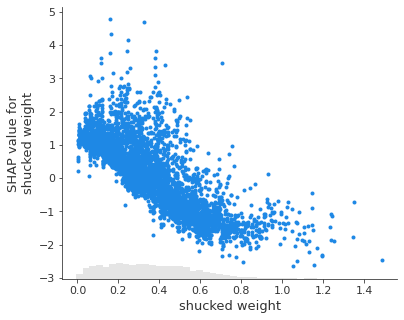

In [28]:
#Plot 2: shucked weight
shap.plots.scatter(shap_values[:,"shucked weight"])

# 3) Custom Plots

In [18]:
#Output SHAP object 
shap_values

.values =
array([[ 9.7818142e-01,  2.2102022e-01,  1.6767840e+00, ...,
         7.8285056e-01, -3.3044200e-02,  4.2346570e-01],
       [-7.5280762e-01, -1.2323786e-01,  1.3336794e+00, ...,
        -5.4065891e-02, -7.0499517e-02,  4.9261141e-01],
       [-3.3046424e-01,  6.5754451e-02,  4.9781185e-01, ...,
         5.7943143e-02,  1.6627842e-01,  2.8612539e-01],
       ...,
       [ 1.7652534e-01,  1.7058614e-01, -1.0987480e+00, ...,
        -1.2453687e-03,  1.4432433e-02,  5.3551301e-02],
       [ 1.0700062e-01,  2.2240385e-01, -9.8834521e-01, ...,
         2.2371762e-02,  1.4795723e-02,  7.1517490e-02],
       [-8.6547263e-02,  1.7283893e-01, -9.0905148e-01, ...,
        -7.0653330e-03,  1.4564530e-02,  1.1492202e-01]], dtype=float32)

.base_values =
array([9.932759, 9.932759, 9.932759, ..., 9.932759, 9.932759, 9.932759],
      dtype=float32)

.data =
array([[0.455 , 0.095 , 0.2245, ..., 1.    , 0.    , 0.    ],
       [0.35  , 0.09  , 0.0995, ..., 1.    , 0.    , 0.    ],
       [0.5

In [19]:
np.shape(shap_values.values)

(4177, 8)

In [20]:
X.head()

,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


In [21]:
# SHAP correlation plot 
corr_matrix = pd.DataFrame(shap_values.values,
                           columns=X.columns).corr()

<AxesSubplot:>

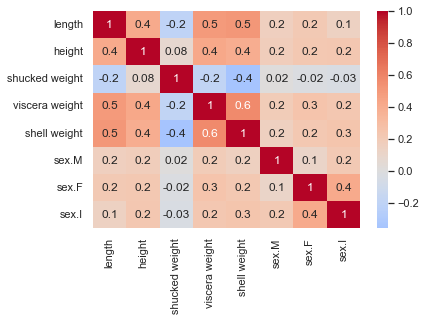

In [22]:
sns.set(font_scale=1)
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center = 0, 
            annot=True,
            fmt='.1g')

# 3.  Binary and categorical target variables 

### Binary target variable

In [41]:
#Binary target varibale
y_bin = [1 if y_>10 else 0 for y_ in y]

#Train model 
model_bin = xgb.XGBClassifier(objective="binary:logistic")
model_bin.fit(X, y_bin)

#Get shap values
explainer = shap.Explainer(model_bin)
shap_values_bin = explainer(X)

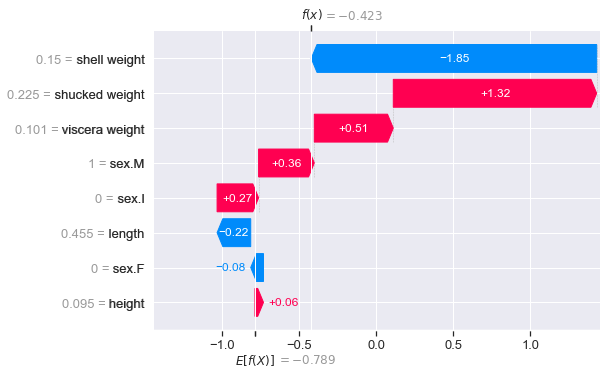

In [24]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values_bin[0])

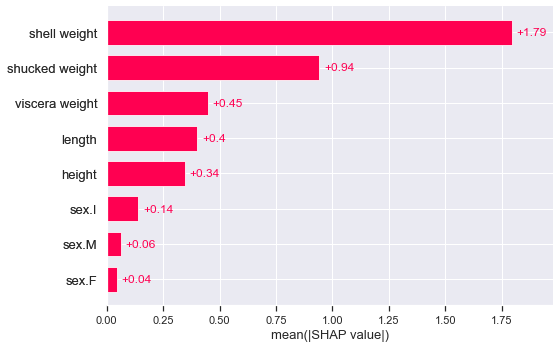

In [42]:
# waterfall plot for first observation
shap.plots.bar(shap_values_bin)

### Categorical target variables

In [25]:
#Categorical target varibale
y_cat = [2 if y_>12 else 1 if y_>8 else 0 for y_ in y]

#Train model 
model_cat = xgb.XGBClassifier(objective="binary:logistic")
model_cat.fit(X, y_cat)

# get probability predictions
model_cat.predict_proba(X)[0]

array([0.25624034, 0.15713139, 0.5866283 ], dtype=float32)

In [60]:
#Get shap values
explainer = shap.Explainer(model_cat)
shap_values_cat= explainer(X)

print(np.shape(shap_values_cat))

(4177, 8, 3)


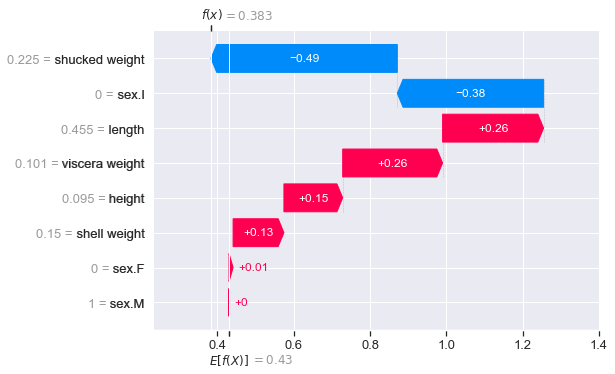

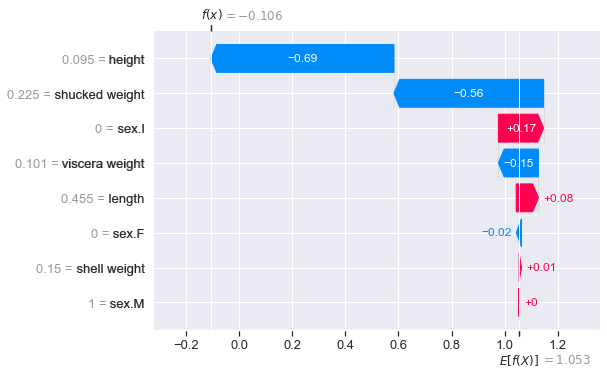

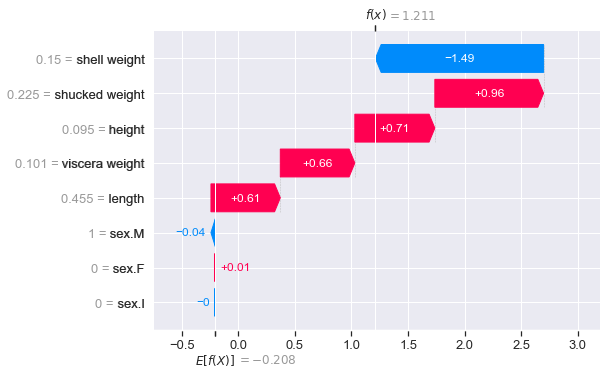

In [27]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values_cat[0,:,0])

# waterfall plot for first observation
shap.plots.waterfall(shap_values_cat[0,:,1])

# waterfall plot for first observation
shap.plots.waterfall(shap_values_cat[0,:,2])

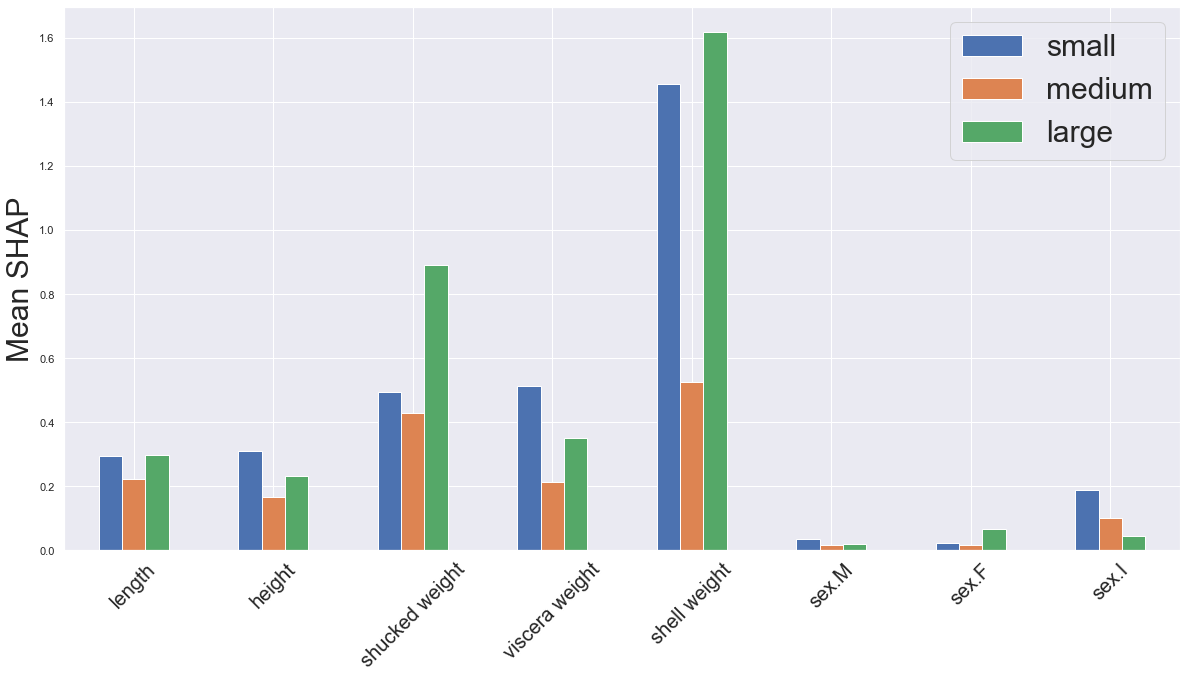

In [50]:
# Calculate mean SHAP values for each class
mean_0 = np.mean(np.abs(shap_values_cat.values[:,:,0]),axis=0)
mean_1 = np.mean(np.abs(shap_values_cat.values[:,:,1]),axis=0)
mean_2 = np.mean(np.abs(shap_values_cat.values[:,:,2]),axis=0)

df = pd.DataFrame({'small':mean_0,'medium':mean_1,'large':mean_2})

# Plot mean SHAP values
fig,ax = plt.subplots(1,1,figsize=(20,10))
df.plot.bar(ax=ax)

ax.set_ylabel('Mean SHAP',size = 30)
ax.set_xticklabels(X.columns,rotation=45,size=20)
ax.legend(fontsize=30)

In [61]:
#Get model predictions
preds = model_cat.predict(X)

new_shap_values = []
for i,pred in enumerate(preds):
    # Get shap values for predicted class
    new_shap_values.append(shap_values_cat.values[i][:,pred])

#replace shap values
shap_values_cat.values = np.array(new_shap_values)
print(shap_values_cat.shape)

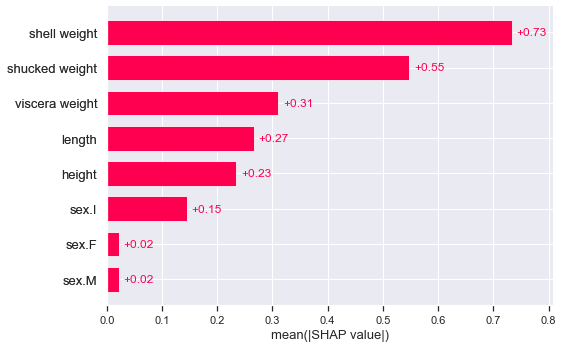

In [66]:
# plot the updated SHAP values 
shap.plots.bar(shap_values_cat)

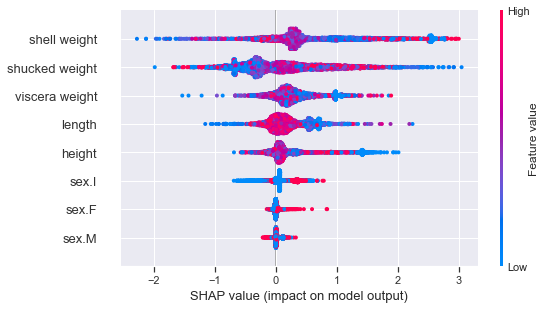

In [62]:
shap.plots.beeswarm(shap_values_cat)

# 4) SHAP interaction value

In [35]:
#Get SHAP interaction values
explainer = shap.Explainer(model)
shap_interaction = explainer.shap_interaction_values(X)

In [37]:
#Get shape of interaction values
np.shape(shap_interaction)

(4177, 8, 8)

In [38]:
# SHAP interaction values for first employee
shap_0 = np.round(shap_interaction[0],2)
pd.DataFrame(shap_0,
             index=X.columns,
             columns=X.columns)

,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
length,-0.30,0.44,0.10,-0.18,0.59,0.27,0.04,0.02
height,0.44,-0.26,0.01,-0.09,-0.02,0.16,-0.01,-0.01
shucked weight,0.10,0.01,1.21,0.00,-0.16,0.45,-0.05,0.11
viscera weight,-0.18,-0.09,0.00,-0.20,0.28,0.06,-0.00,0.03
shell weight,0.59,-0.02,-0.16,0.28,-1.87,0.14,0.06,0.14
sex.M,0.27,0.16,0.45,0.06,0.14,-0.30,0.00,0.00
sex.F,0.04,-0.01,-0.05,-0.00,0.06,0.00,-0.07,0.00
sex.I,0.02,-0.01,0.11,0.03,0.14,0.00,0.00,0.13


## Mean SHAP interaction values

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'length'),
  Text(0, 1.5, 'height'),
  Text(0, 2.5, 'shucked weight'),
  Text(0, 3.5, 'viscera weight'),
  Text(0, 4.5, 'shell weight'),
  Text(0, 5.5, 'sex.M'),
  Text(0, 6.5, 'sex.F'),
  Text(0, 7.5, 'sex.I')])

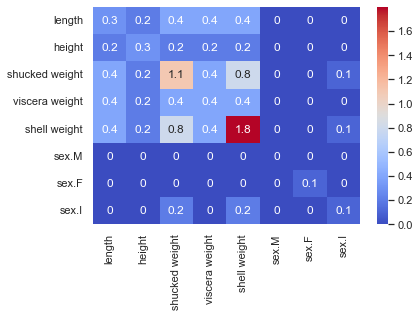

In [39]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
mean_shap = np.round(mean_shap,1)

df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
sns.set(font_scale=1)
sns.heatmap(df,cmap='coolwarm',annot=True)
plt.yticks(rotation=0) 

## Dependence plot

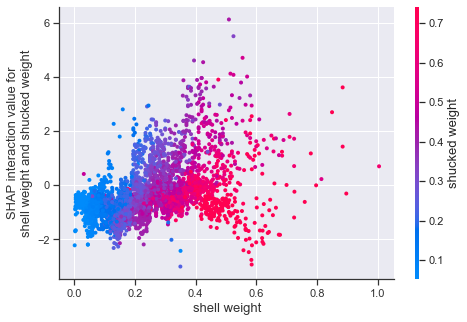

In [40]:
shap.dependence_plot(
    ("shell weight", "shucked weight"),
    shap_interaction, X,
    display_features=X)

Text(0, 0.5, 'shell weight')

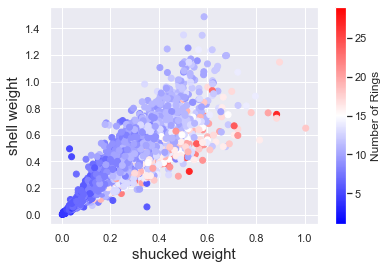

In [41]:
#Interaction between shell weight and shucked weight
plt.scatter(data["shell weight"],
            data["shucked weight"],
            c=data["rings"],
            cmap='bwr')
plt.colorbar(label="Number of Rings", 
             orientation="vertical")

plt.xlabel('shucked weight',size=15)
plt.ylabel('shell weight',size=15)

# 5) SHAP for categorical variables

In [42]:
X.head()

,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


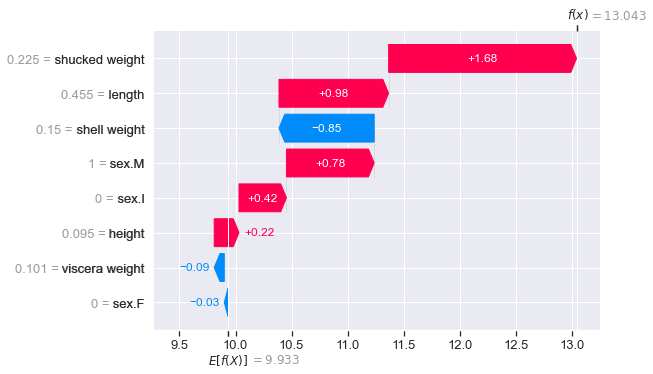

In [43]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [44]:
new_shap_values = []

#loop over all shap values:
for values in shap_values.values:
    
    #sum SHAP values for sex 
    sv = list(values)
    sv = sv[0:5] + [sum(sv[5:8])]
    
    new_shap_values.append(sv)

In [45]:
#replace shap values
shap_values.values = np.array(new_shap_values)

#replace data with categorical feature values 
X_cat = data[["length","height",
              "shucked weight","viscera weight",
              "shell weight","sex"]]
shap_values.data = np.array(X_cat)

#update feature names
shap_values.feature_names = list(X_cat.columns)

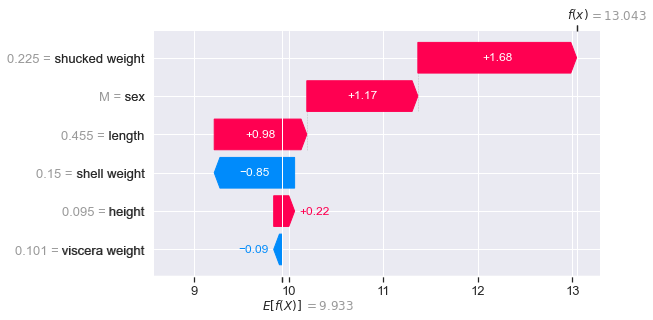

In [46]:
shap.plots.waterfall(shap_values[0])

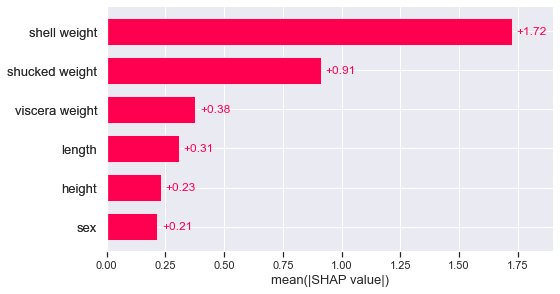

In [47]:
shap.plots.bar(shap_values)

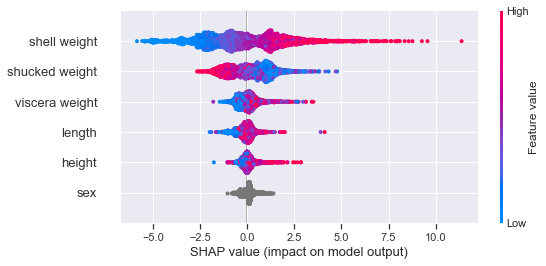

In [48]:
shap.plots.beeswarm(shap_values)

Text(0.5, 0, 'Sex')

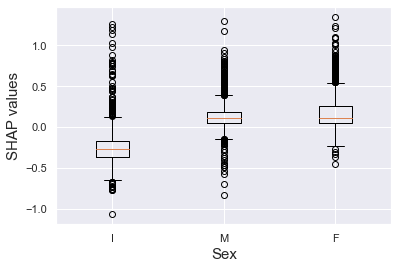

In [49]:
#get shaply values and data
sex_values = shap_values[:,"sex"].values
sex_data = shap_values[:,"sex"].data
sex_categories = ['I','M','F']

#split sex shap values based on category
sex_groups = []
for s in sex_categories:
    relevant_values = sex_values[sex_data == s]
    sex_groups.append(relevant_values)
    
#plot boxplot
plt.boxplot(sex_groups,labels=sex_categories)

plt.ylabel('SHAP values',size=15)
plt.xlabel('Sex',size=15)

In [ ]:
#Create for placeholder SHAP values
shap_values_sex = explainer(X)

#get shaply values and data
sex_values = shap_values[:,"sex"].values
sex_data = shap_values[:,"sex"].data
sex_categories = ['I','M','F']

#Create new SHAP values array

#Split odor SHAP values by unique odor categories
new_shap_values = [np.array(pd.Series(sex_values)[sex_data==s]) 
                    for s in sex_categories]

#Each sublist needs to be the same length
max_len = max([len(v) for v in new_shap_values])
new_shap_values = [np.append(vs,[np.nan]*(max_len - len(vs))) for vs in new_shap_values]
new_shap_values = np.array(new_shap_values)

#transpost matrix so categories are columns and SHAP values are rows
new_shap_values = new_shap_values.transpose()

#replace shap values
shap_values_sex.values = np.array(new_shap_values)

#replace data with placeholder array
shap_values_sex.data = np.array([[0]*len(sex_categories)]*max_len)

#replace base data with placeholder array
shap_values_sex.base = np.array([0]*max_len)

#replace feature names with category labels
shap_values_sex.feature_names = list(sex_categories)

#Use beeswarm as before
shap.plots.beeswarm(shap_values_sex,color_bar=False)

In [1]:
import warnings
warnings.filterwarnings('ignore')